In [113]:
%load_ext autoreload
%autoreload 2 
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import json
import numpy as np
from matplotlib import pyplot as plt
from utils import (
    BiLSTMMultilabel,
    BiLSTMClassifierMTL,
    BiLSTMClassifier,
    SentenceEncoder,
    SentenceEncoder2,
    EmbeddingsDataset,
    custom_collator,
    compute_class_weights,
    load_documents_with_names,
    load_paths,
    compute_label_distribution,
    load_crf_constraints)
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel, set_seed
from tqdm import tqdm
from tabulate import tabulate
from IPython.display import clear_output
from torchmetrics import Accuracy, Recall, F1Score

torch.cuda.empty_cache()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA L4


In [115]:
task = 'multilabel'

In [116]:
LABELS_DICT_PATH = "dataset/labels_dict.json"

labels_dict = json.load(open(LABELS_DICT_PATH, "r"))
data_paths = load_paths("dataset/split_paths.json")
train_documents = load_documents_with_names(data_paths['train'])
val_documents = load_documents_with_names(data_paths['val'])

label_dist = compute_label_distribution(train_documents, labels_dict, task)
class_weights = compute_class_weights(train_documents, labels_dict, task)
#constraints = load_crf_constraints("dataset/constraints.json")

tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
sentence_encoder_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
sentence_encoder = SentenceEncoder(sentence_encoder_model)
sentence_encoder = torch.nn.DataParallel(sentence_encoder) # wrapper to use multiple GPUs

print("Encoding training sequences...")
trainset_save_path = "dataset/embeddings/" + task + "_train.pkl"
trainset = EmbeddingsDataset(train_documents, tokenizer, sentence_encoder, device, labels_dict, task, return_labels=True)
trainset.save(trainset_save_path)

print("\nEncoding validation sequences...")
valset_save_path = "dataset/embeddings/" + task + "_val.pkl"
valset = EmbeddingsDataset(val_documents, tokenizer, sentence_encoder, device, labels_dict, task, return_labels=True)
valset.save(valset_save_path)

Encoding training sequences...


  0%|          | 0/40 [00:00<?, ?document/s]

Dataset saved to dataset/embeddings/multilabel_train.pkl

Encoding validation sequences...


  0%|          | 0/5 [00:00<?, ?document/s]

Dataset saved to dataset/embeddings/multilabel_val.pkl


In [117]:
# load training saved sequences
trainset_load_path = "dataset/embeddings/" + task + "_train.pkl"
valset_load_path = "dataset/embeddings/" + task + "_val.pkl"
trainset = EmbeddingsDataset.load(trainset_load_path)
valset = EmbeddingsDataset.load(valset_load_path)

Dataset loaded from dataset/embeddings/multilabel_train.pkl
Number of sequences loaded: 51

Dataset loaded from dataset/embeddings/multilabel_val.pkl
Number of sequences loaded: 5



In [121]:
# parameters for the training loop
BATCH_SIZE = 16
EPOCHS = 300
LR = 1e-3
WEIGHT_DECAY = 0.01
TRAIN_SEED = 18

print_trainable = False
save_best_score = True
save_at_epoch = 100

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(TRAIN_SEED), collate_fn=custom_collator)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collator)

#model = BiLSTMClassifierMTL(num_labels=len(labels_dict), class_weights=class_weights.to(device), alpha=2, binary_loss_coef=5)
model = BiLSTMMultilabel(num_labels=len(labels_dict), class_weights=class_weights.to(device))
model.to(device)

# print trainable parameters
if print_trainable:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [122]:
# Initialize metrics
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []
train_recall_scores = []
val_recall_scores = []

best_metric_score = 0
epoch_saved = 0

# Initialize epoch metrics
epoch_metrics = []
if task == 'multilabel':
    headers = ["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc", "Train F1", "Val F1"]
elif task == 'multiclass':
    headers = ["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc", "Train F1", "Val F1", "Train SwapAcc", "Val SwapAcc"]

# Metric trackers
if task == 'multilabel':
    accuracy_metric = Accuracy(task='multilabel', average='micro', num_labels=len(labels_dict), ignore_index=-100).to(device)
    recall_metric = Recall(task='multilabel', average='weighted', num_labels=len(labels_dict), ignore_index=-100).to(device)
    f1_metric = F1Score(task='multilabel', average='weighted', num_labels=len(labels_dict), ignore_index=-100).to(device)
elif task == 'multiclass':
    accuracy_metric = Accuracy(task='multiclass', average='micro', num_classes=len(labels_dict), ignore_index=-100).to(device)
    recall_metric = Recall(task='multiclass', average='weighted', num_classes=len(labels_dict), ignore_index=-100).to(device)
    f1_metric = F1Score(task='multiclass', average='weighted', num_classes=len(labels_dict), ignore_index=-100).to(device)
    swap_accuracy_metric = Accuracy(task='binary', average='micro', num_classes=2).to(device)

# Epoch loop with tqdm
progress_bar = tqdm(range(EPOCHS), desc="Training Progress", unit="epoch", leave=False)
for epoch in progress_bar:
    # Training
    model.train()
    train_loss = 0
    train_acc = 0
    accuracy_metric.reset()
    f1_metric.reset()
    recall_metric.reset()
    if task == 'multiclass':
        swap_accuracy_metric.reset()

    for batch in train_loader:
        embeddings = batch["input_embeddings"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        if task == 'multilabel':
            loss, preds = model(embeddings, attention_masks, labels)
            preds = preds.view(-1, preds.size(-1))
            labels = labels.view(-1, labels.size(-1))
            padding_mask = ~(labels == -100).all(dim=1)
            preds = preds[padding_mask]
            labels = labels[padding_mask]
        elif task == 'multiclass':
            loss, preds, swap_labels, swap_preds = model(embeddings, attention_masks, labels)
            swap_accuracy_metric.update(swap_preds, swap_labels)
            
        train_loss += loss.item()
        accuracy_metric.update(preds, labels)
        f1_metric.update(preds, labels)
        recall_metric.update(preds, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute epoch-level training metrics
    epoch_train_acc = accuracy_metric.compute().item()
    epoch_train_f1 = f1_metric.compute().item()
    epoch_train_recall = recall_metric.compute().item()
    if task == 'multiclass':
        epoch_train_swap_acc = swap_accuracy_metric.compute().item()
    
    # Validation
    model.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()
    recall_metric.reset()
    if task == 'multiclass':
        swap_accuracy_metric.reset()

    with torch.no_grad():
        for batch in val_loader:
            embeddings = batch["input_embeddings"].to(device)
            attention_masks = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            if task == 'multilabel':
                loss, preds = model(embeddings, attention_masks, labels)
                preds = preds.view(-1, preds.size(-1))
                labels = labels.view(-1, labels.size(-1))
                padding_mask = ~(labels == -100).all(dim=1)
                preds = preds[padding_mask]
                labels = labels[padding_mask]
            elif task == 'multiclass':
                loss, preds, swap_labels, swap_preds = model(embeddings, attention_masks, labels)
                swap_accuracy_metric.update(swap_preds, swap_labels)
                
            val_loss += loss.item()
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)
            recall_metric.update(preds, labels)
    
    # Compute epoch-level validation metrics
    epoch_val_acc = accuracy_metric.compute().item()
    epoch_val_f1 = f1_metric.compute().item()
    epoch_val_recall = recall_metric.compute().item()
    if task == 'multiclass':
        epoch_val_swap_acc = swap_accuracy_metric.compute().item()
    metric_to_optimize = epoch_val_f1

    # Save the best model
    if save_best_score and metric_to_optimize > best_metric_score:
        best_metric_score = metric_to_optimize
        torch.save(model.state_dict(), "models/bestmodel.pt")
        epoch_saved = epoch + 1
        
    if save_at_epoch == epoch + 1:
        torch.save(model.state_dict(), "models/model_epoch"+str(save_at_epoch)+".pt")

    # Update metrics
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_f1_scores.append(epoch_train_f1)
    val_f1_scores.append(epoch_val_f1)
    train_recall_scores.append(epoch_train_recall)
    val_recall_scores.append(epoch_val_recall)

    epoch_metrics.append([
        epoch + 1,
        train_loss / len(train_loader),
        val_loss / len(val_loader),
        epoch_train_acc,
        epoch_val_acc,
        epoch_train_f1,
        epoch_val_f1,
        #epoch_train_swap_acc,
        #epoch_val_swap_acc,
    ])

    # Update the progress bar description
    progress_bar.set_description(f"Epoch {epoch + 1}/{EPOCHS} - Val F1: {epoch_val_f1:.4f}")
    
    # Clear and display the table
    clear_output()
    tqdm.write(tabulate(epoch_metrics, headers=headers, floatfmt=".4f"))

# Save training and validation metrics
np.save("logs/train_losses1.npy", np.array(train_losses))
np.save("logs/val_losses1.npy", np.array(val_losses))
np.save("logs/train_f1_scores1.npy", np.array(train_f1_scores))
np.save("logs/val_f1_scores1.npy", np.array(val_f1_scores))
np.save("logs/train_recall_scores1.npy", np.array(train_recall_scores))
np.save("logs/val_recall_scores1.npy", np.array(val_recall_scores))

  Epoch    Train Loss    Val Loss    Train Acc    Val Acc    Train F1    Val F1
-------  ------------  ----------  -----------  ---------  ----------  --------
      1        1.4562      0.9043       0.4779     0.6049      0.5142    0.0199
      2        1.0633      0.8930       0.6574     0.5245      0.2067    0.0392
      3        1.1440      0.8344       0.6109     0.6750      0.2280    0.7919
      4        0.9200      0.7730       0.6542     0.5934      0.6169    0.7893
      5        0.8863      0.7502       0.7087     0.7628      0.5698    0.0346
      6        0.8471      0.7256       0.8032     0.7090      0.1729    0.0392
      7        0.8100      0.6980       0.7775     0.6884      0.1776    0.0429
      8        0.8899      0.6320       0.7798     0.6927      0.3034    0.7738
      9        0.7659      0.6948       0.7204     0.6751      0.6550    0.7131
     10        0.9684      0.5980       0.7366     0.8321      0.6266    0.7879
     11        0.7766      0.7347       

Best model saved at epoch 296 with score: 0.8905


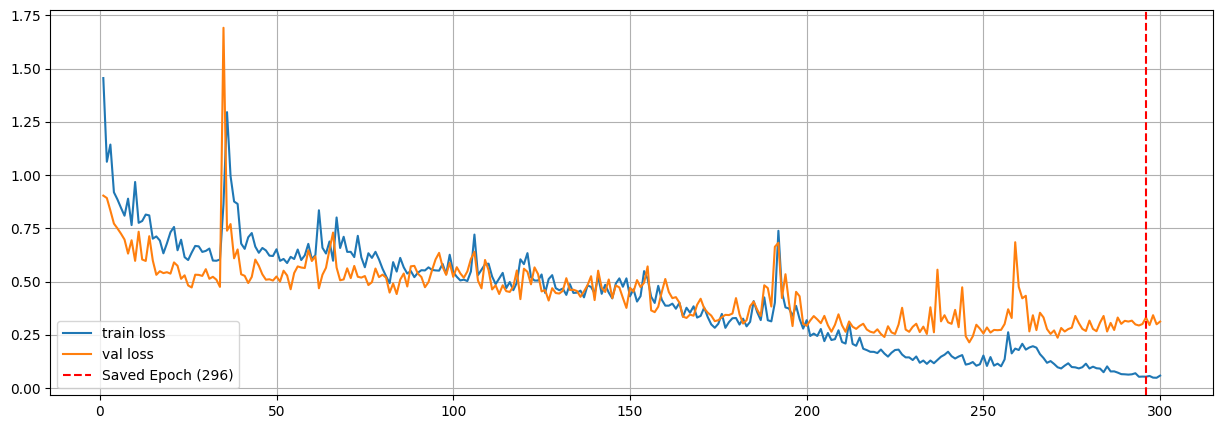

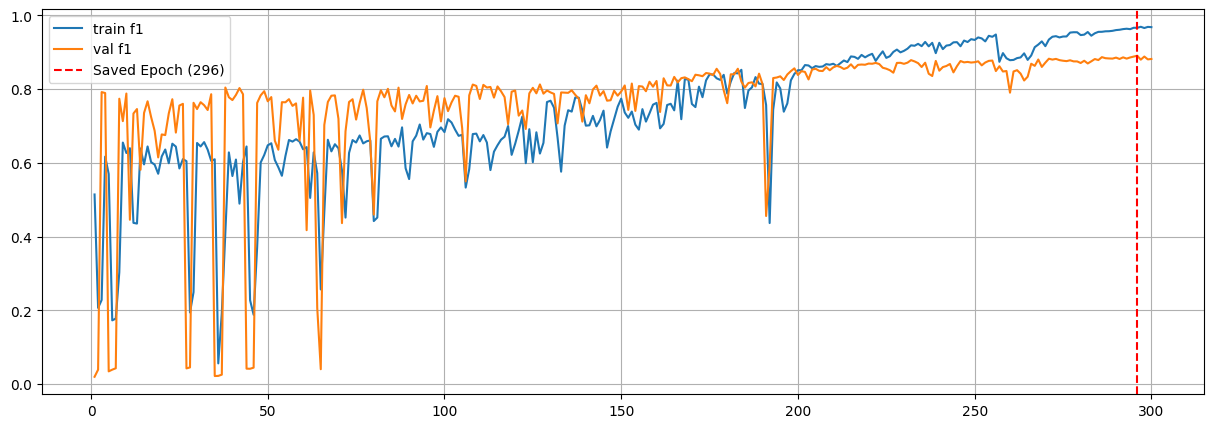

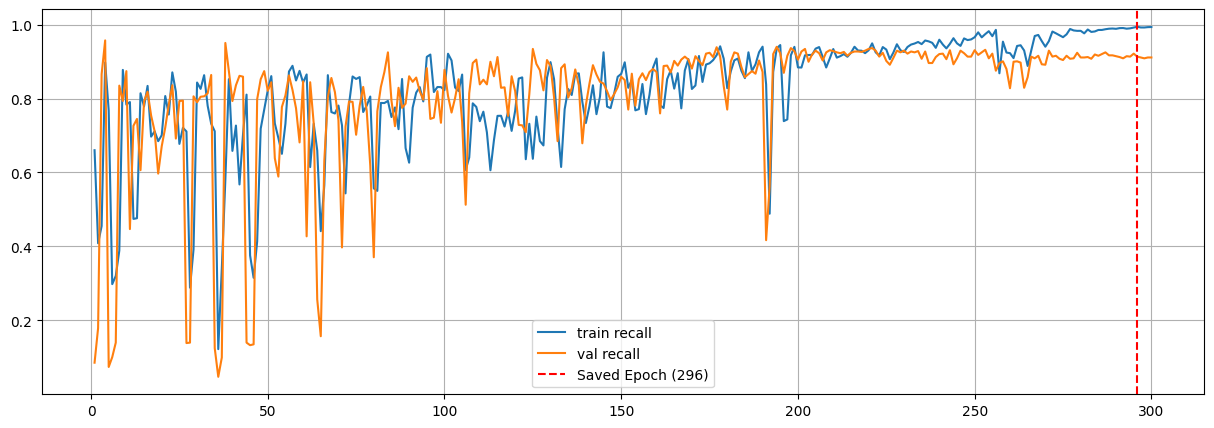

In [123]:
print(f"Best model saved at epoch {epoch_saved} with score: {best_metric_score:.4f}")

x = np.arange(1, EPOCHS+1)
plt.figure(figsize=(15, 5))
plt.plot(x,train_losses, label="train loss")
plt.plot(x,val_losses, label="val loss")
plt.axvline(x=epoch_saved, color='r', linestyle='--', label=f'Saved Epoch ({epoch_saved})')
#plt.xticks(x)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(x,train_f1_scores, label="train f1")
plt.plot(x,val_f1_scores, label="val f1")
plt.axvline(x=epoch_saved, color='r', linestyle='--', label=f'Saved Epoch ({epoch_saved})')
#plt.xticks(x)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(x,train_recall_scores, label="train recall")
plt.plot(x,val_recall_scores, label="val recall")
plt.axvline(x=epoch_saved, color='r', linestyle='--', label=f'Saved Epoch ({epoch_saved})')
#plt.xticks(x)
plt.grid(True)
plt.legend()
plt.show()